In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob as glob
import random
import cv2
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# from tqdm import tqdm
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F

from torch.utils.data import Dataset
from torchvision import io, datasets, models, transforms

random.seed(0)
torch.manual_seed(0)

In [2]:
os.getcwd()

'/home/anhnguyen/Documents/testSOTACrackClassification/models/training'

In [3]:
data_dir = '../../datasets/DATA_Maguire_20180517_ALL'
img_list = glob.glob(f'{data_dir}/**/*.jpg', recursive=True)
all_Y = [1 if 'U' not in x else 0 for x in img_list]


[0 1] [47608  8484]


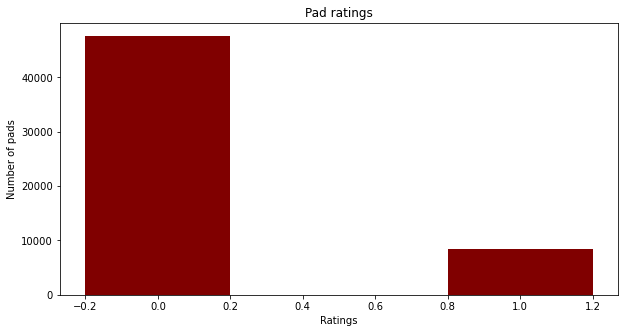

In [4]:
label_values = all_Y
values, counts = np.unique(label_values, return_counts = True)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, counts, color ='maroon',
        width = 0.4)
print(values, counts)
 
plt.xlabel("Ratings")
plt.ylabel("Number of pads")
plt.title("Pad ratings")
plt.show()
num_classes = len(values)

In [5]:
#Sample for balance dataset:
non_crack_img_list = [path for path, element in zip(img_list, all_Y) if element == 0]
non_crack_to_train = random.sample(non_crack_img_list, counts[1])
non_crack_left = [x for x in non_crack_img_list if x not in non_crack_to_train]
print(len(non_crack_to_train), len(non_crack_left))

8484 39124


In [6]:
crack_img_list = [path for path, element in zip(img_list, all_Y) if element == 1]
print(len(crack_img_list))

8484


In [7]:
X = crack_img_list+non_crack_to_train
print(len(X))
y = [1 for x in range(len(crack_img_list))] + [0 for x in range(len(non_crack_to_train))]
print(np.unique(y, return_counts=True))

16968
(array([0, 1]), array([8484, 8484]))


In [8]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify = y_train)
print(len(X_train), len(X_val), len(X_test))

10180 3394 3394


In [9]:
#Adding the rest of the non-crack into y_test
X_test.extend(non_crack_left)
y_test.extend([0 for x in non_crack_left])

In [10]:
#create dataset from dataframe
class CrackDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        label = torch.tensor(self.y[idx],dtype=torch.long)
        
        img_path = self.X[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if(img.shape[:2] != (224,224)):
            img = cv2.resize(img,(224,224))
        
        img = Image.fromarray(np.uint8(img)).convert('RGB')

        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, label

In [11]:
from sklearn.model_selection import train_test_split  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
#         transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
#         normalize
    ]),
    'validation':
    transforms.Compose([
#         transforms.Resize((224,224)),
        transforms.ToTensor(),
#         normalize
    ]),
}

#load data from a list of paths
image_datasets = {
    'train': 
    CrackDataset(X_train, y_train, transforms=data_transforms['train']),
    'validation': 
    CrackDataset(X_val, y_val, transforms=data_transforms['validation']),
    'test': 
    CrackDataset(X_test, y_test, transforms=data_transforms['validation'])
}

batch_size = 32
num_workers = 4
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=num_workers),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers),
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers),
}



cuda:0


In [12]:
#Model define
model = models.mobilenet_v2(pretrained=True, progress=False).to(device)


In [13]:
# for param in model.parameters():
#     param.requires_grad = False   

num_classes = 2
model.classifier = nn.Sequential(
               nn.Linear(1280, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, num_classes)
               ).to(device)

In [14]:
# #Naive class weights
# from sklearn.utils import class_weight
# class_weights_array = class_weight.compute_class_weight('balanced', classes = np.unique(np.asarray(labels)), y = np.asarray(labels))
# class_weights = torch.from_numpy(class_weights_array)
# class_weights = torch.tensor(class_weights, dtype = torch.float32).to(device)
# print('class_weight_array',class_weights)

In [15]:
os.getcwd()

'/home/anhnguyen/Documents/testSOTACrackClassification/models/training'

In [16]:
model_save_path = "weights"
os.makedirs(model_save_path, exist_ok = True)

In [17]:
criterion = nn.CrossEntropyLoss()#weight = class_weights)
lr=0.01
optimizer = optim.Adam(model.parameters(), lr = lr)
f1_diff_threshold = 0.0005
patience = 100
num_epochs = 300
run_name = model_save_path.split('/')[-1]
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 33, verbose = True)

def train_model(model, 
                criterion, 
                optimizer, 
                num_epochs=3, 
                f1_diff_threshold = f1_diff_threshold, 
                patience = patience, 
                model_save_path = model_save_path,
                run_name = run_name,
               ):
    validation_f1s = []
    max_f1_index = 0
    num_epochs_not_improving = 0
    metrics = {
        'validation_f1s': [], 
        'validation_accs': [],
        'validation_loss': [],
        'training_f1s': [], 
        'training_accs': [], 
        'training_loss': [],
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            pred_c = np.array([])
            label_c = np.array([])

            print(phase, ':')

            for inputs, labels in tqdm(dataloaders[phase]):                
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
#                     loss = CB_loss(labels, logits, samples_per_cls, no_of_classes,loss_type, beta, gamma)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                label_c = np.concatenate((label_c, labels.data.cpu().numpy()))
                pred_c = np.concatenate((pred_c, preds.cpu().numpy()))
            f1 = f1_score(y_true = label_c, y_pred = pred_c, average = 'micro')
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = (running_corrects*1.0) / len(image_datasets[phase])


            if phase == 'validation':
                cf = confusion_matrix(label_c, pred_c)
                print(cf)

                validation_f1s.append(f1)
                metrics['validation_f1s'].append(f1)
                metrics['validation_accs'].append(float(epoch_acc))
                metrics['validation_loss'].append(epoch_loss)

                if f1 - validation_f1s[max_f1_index] > f1_diff_threshold:
                    max_f1_index = len(validation_f1s) - 1
                    num_epochs_not_improving = 0

                    # Save model
                    print(f"Saving model at epoch {epoch}")
                    torch.save(model, f'{model_save_path}/model.pth')

                elif f1 - validation_f1s[max_f1_index] <= f1_diff_threshold:
                    num_epochs_not_improving += 1
                    if(num_epochs_not_improving > patience):
                        torch.save(model, f'{model_save_path}/last_model.pth')
                        print(f'Early Stopping at epoch {epoch} ')
                        return model

            elif phase == 'train':
                metrics['training_f1s'].append(f1)
                metrics['training_accs'].append(float(epoch_acc))
                metrics['training_loss'].append(epoch_loss)
                scheduler.step(epoch_loss)

            print('{} loss: {:.4f}, acc: {:.4f}, f1: {:.4f}'.format(phase,
                                                                    epoch_loss,
                                                                    epoch_acc, 
                                                                    f1))

    torch.save(model, f'{model_save_path}/last_model.pth')
    print(f'Ran all {num_epochs} epochs')
    return model, metrics



In [ ]:
model_trained, metrics = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.7466, acc: 0.5635, f1: 0.5635
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[ 511 1186]
 [ 294 1403]]
validation loss: 0.6866, acc: 0.5639, f1: 0.5639
Epoch 2/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.6676, acc: 0.6005, f1: 0.6005
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1353  344]
 [ 948  749]]
validation loss: 0.6645, acc: 0.6193, f1: 0.6193
Epoch 3/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.6430, acc: 0.6412, f1: 0.6412
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[ 972  725]
 [ 425 1272]]
validation loss: 0.6293, acc: 0.6612, f1: 0.6612
Epoch 4/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.6398, acc: 0.6439, f1: 0.6439
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[ 906  791]
 [ 356 1341]]
validation loss: 0.6286, acc: 0.6621, f1: 0.6621
Epoch 5/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.6228, acc: 0.6577, f1: 0.6577
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1359  338]
 [ 835  862]]
validation loss: 0.6268, acc: 0.6544, f1: 0.6544
Epoch 6/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.6147, acc: 0.6696, f1: 0.6696
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1224  473]
 [ 575 1122]]
validation loss: 0.5951, acc: 0.6912, f1: 0.6912
Epoch 7/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.6111, acc: 0.6633, f1: 0.6633
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[ 727  970]
 [ 202 1495]]
validation loss: 0.6161, acc: 0.6547, f1: 0.6547
Epoch 8/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.6041, acc: 0.6781, f1: 0.6781
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1519  178]
 [1159  538]]
validation loss: 0.7751, acc: 0.6061, f1: 0.6061
Epoch 9/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.5957, acc: 0.6771, f1: 0.6771
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[ 669 1028]
 [ 294 1403]]
validation loss: 0.6268, acc: 0.6105, f1: 0.6105
Epoch 10/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.5873, acc: 0.6866, f1: 0.6866
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[ 487 1210]
 [  80 1617]]
validation loss: 0.6251, acc: 0.6199, f1: 0.6199
Epoch 11/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.5750, acc: 0.6949, f1: 0.6949
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1561  136]
 [ 945  752]]
validation loss: 0.6024, acc: 0.6815, f1: 0.6815
Epoch 12/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.6018, acc: 0.6657, f1: 0.6657
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1526  171]
 [ 911  786]]
validation loss: 0.5721, acc: 0.6812, f1: 0.6812
Epoch 13/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.5675, acc: 0.7027, f1: 0.7027
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1253  444]
 [ 516 1181]]
validation loss: 0.5615, acc: 0.7171, f1: 0.7171
Epoch 14/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.5478, acc: 0.7161, f1: 0.7161
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1353  344]
 [ 557 1140]]
validation loss: 0.5309, acc: 0.7345, f1: 0.7345
Epoch 15/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.5322, acc: 0.7309, f1: 0.7309
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1528  169]
 [ 831  866]]
validation loss: 0.5572, acc: 0.7054, f1: 0.7054
Epoch 16/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.5178, acc: 0.7438, f1: 0.7438
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1588  109]
 [ 878  819]]
validation loss: 0.6303, acc: 0.7092, f1: 0.7092
Epoch 17/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.5184, acc: 0.7425, f1: 0.7425
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1291  406]
 [ 467 1230]]
validation loss: 0.5191, acc: 0.7428, f1: 0.7428
Epoch 18/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.5070, acc: 0.7574, f1: 0.7574
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1542  155]
 [ 698  999]]
validation loss: 0.5186, acc: 0.7487, f1: 0.7487
Epoch 19/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4917, acc: 0.7640, f1: 0.7640
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1347  350]
 [ 462 1235]]
validation loss: 0.4985, acc: 0.7608, f1: 0.7608
Epoch 20/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4899, acc: 0.7649, f1: 0.7649
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1505  192]
 [ 617 1080]]
validation loss: 0.4898, acc: 0.7616, f1: 0.7616
Epoch 21/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4757, acc: 0.7727, f1: 0.7727
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1381  316]
 [ 620 1077]]
validation loss: 0.5667, acc: 0.7242, f1: 0.7242
Epoch 22/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.5400, acc: 0.7177, f1: 0.7177
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1491  206]
 [ 687 1010]]
validation loss: 0.5267, acc: 0.7369, f1: 0.7369
Epoch 23/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4957, acc: 0.7571, f1: 0.7571
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1450  247]
 [ 513 1184]]
validation loss: 0.4721, acc: 0.7761, f1: 0.7761
Epoch 24/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4657, acc: 0.7789, f1: 0.7789
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1493  204]
 [ 518 1179]]
validation loss: 0.4421, acc: 0.7873, f1: 0.7873
Epoch 25/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4496, acc: 0.7914, f1: 0.7914
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1535  162]
 [ 573 1124]]
validation loss: 0.4716, acc: 0.7834, f1: 0.7834
Epoch 26/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4515, acc: 0.7924, f1: 0.7924
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1289  408]
 [ 322 1375]]
validation loss: 0.4463, acc: 0.7849, f1: 0.7849
Epoch 27/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4360, acc: 0.8013, f1: 0.8013
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1605   92]
 [ 629 1068]]
validation loss: 0.4599, acc: 0.7876, f1: 0.7876
Epoch 28/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4363, acc: 0.7981, f1: 0.7981
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1412  285]
 [ 392 1305]]
validation loss: 0.4345, acc: 0.8005, f1: 0.8005
Epoch 29/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4339, acc: 0.8019, f1: 0.8019
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1414  283]
 [ 399 1298]]
validation loss: 0.4322, acc: 0.7991, f1: 0.7991
Epoch 30/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4309, acc: 0.8018, f1: 0.8018
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1566  131]
 [ 543 1154]]
validation loss: 0.4427, acc: 0.8014, f1: 0.8014
Epoch 31/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4251, acc: 0.7995, f1: 0.7995
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1366  331]
 [ 325 1372]]
validation loss: 0.4321, acc: 0.8067, f1: 0.8067
Epoch 32/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4403, acc: 0.7947, f1: 0.7947
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1541  156]
 [ 462 1235]]
validation loss: 0.4156, acc: 0.8179, f1: 0.8179
Epoch 33/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4226, acc: 0.8084, f1: 0.8084
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1476  221]
 [ 414 1283]]
validation loss: 0.4367, acc: 0.8129, f1: 0.8129
Epoch 34/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4131, acc: 0.8166, f1: 0.8166
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1409  288]
 [ 323 1374]]
validation loss: 0.4057, acc: 0.8200, f1: 0.8200
Epoch 35/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4077, acc: 0.8136, f1: 0.8136
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1509  188]
 [ 420 1277]]
validation loss: 0.4034, acc: 0.8209, f1: 0.8209
Epoch 36/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4060, acc: 0.8176, f1: 0.8176
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1618   79]
 [ 634 1063]]
validation loss: 0.4657, acc: 0.7899, f1: 0.7899
Epoch 37/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4090, acc: 0.8153, f1: 0.8153
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1639   58]
 [ 851  846]]
validation loss: 0.5501, acc: 0.7322, f1: 0.7322
Epoch 38/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4058, acc: 0.8197, f1: 0.8197
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1576  121]
 [ 436 1261]]
validation loss: 0.3951, acc: 0.8359, f1: 0.8359
Epoch 39/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3958, acc: 0.8219, f1: 0.8219
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1463  234]
 [ 398 1299]]
validation loss: 0.4195, acc: 0.8138, f1: 0.8138
Epoch 40/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3933, acc: 0.8236, f1: 0.8236
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1355  342]
 [ 301 1396]]
validation loss: 0.4071, acc: 0.8105, f1: 0.8105
Epoch 41/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.4071, acc: 0.8158, f1: 0.8158
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1618   79]
 [ 536 1161]]
validation loss: 0.4225, acc: 0.8188, f1: 0.8188
Epoch 42/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3923, acc: 0.8258, f1: 0.8258
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1495  202]
 [ 388 1309]]
validation loss: 0.3941, acc: 0.8262, f1: 0.8262
Epoch 43/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3925, acc: 0.8260, f1: 0.8260
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1505  192]
 [ 391 1306]]
validation loss: 0.3886, acc: 0.8282, f1: 0.8282
Epoch 44/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3902, acc: 0.8251, f1: 0.8251
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1399  298]
 [ 314 1383]]
validation loss: 0.3930, acc: 0.8197, f1: 0.8197
Epoch 45/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3839, acc: 0.8279, f1: 0.8279
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1364  333]
 [ 288 1409]]
validation loss: 0.4125, acc: 0.8170, f1: 0.8170
Epoch 46/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3801, acc: 0.8324, f1: 0.8324
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1562  135]
 [ 445 1252]]
validation loss: 0.3942, acc: 0.8291, f1: 0.8291
Epoch 47/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3713, acc: 0.8364, f1: 0.8364
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1536  161]
 [ 420 1277]]
validation loss: 0.3859, acc: 0.8288, f1: 0.8288
Epoch 48/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3784, acc: 0.8333, f1: 0.8333
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1580  117]
 [ 499 1198]]
validation loss: 0.4174, acc: 0.8185, f1: 0.8185
Epoch 49/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3802, acc: 0.8291, f1: 0.8291
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1366  331]
 [ 313 1384]]
validation loss: 0.4113, acc: 0.8103, f1: 0.8103
Epoch 50/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3772, acc: 0.8349, f1: 0.8349
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1428  269]
 [ 301 1396]]
validation loss: 0.3848, acc: 0.8321, f1: 0.8321
Epoch 51/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3746, acc: 0.8354, f1: 0.8354
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1480  217]
 [ 343 1354]]
validation loss: 0.3844, acc: 0.8350, f1: 0.8350
Epoch 52/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3868, acc: 0.8247, f1: 0.8247
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1465  232]
 [ 369 1328]]
validation loss: 0.4043, acc: 0.8229, f1: 0.8229
Epoch 53/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3717, acc: 0.8392, f1: 0.8392
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1421  276]
 [ 284 1413]]
validation loss: 0.3843, acc: 0.8350, f1: 0.8350
Epoch 54/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3661, acc: 0.8371, f1: 0.8371
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1450  247]
 [ 311 1386]]
validation loss: 0.3743, acc: 0.8356, f1: 0.8356
Epoch 55/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3618, acc: 0.8402, f1: 0.8402
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1414  283]
 [ 269 1428]]
validation loss: 0.3811, acc: 0.8374, f1: 0.8374
Epoch 56/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3665, acc: 0.8398, f1: 0.8398
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1430  267]
 [ 297 1400]]
validation loss: 0.3825, acc: 0.8338, f1: 0.8338
Epoch 57/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3681, acc: 0.8396, f1: 0.8396
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1525  172]
 [ 376 1321]]
validation loss: 0.3846, acc: 0.8385, f1: 0.8385
Epoch 58/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3615, acc: 0.8415, f1: 0.8415
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1570  127]
 [ 470 1227]]
validation loss: 0.3953, acc: 0.8241, f1: 0.8241
Epoch 59/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3570, acc: 0.8440, f1: 0.8440
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1559  138]
 [ 382 1315]]
validation loss: 0.3600, acc: 0.8468, f1: 0.8468
Epoch 60/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3647, acc: 0.8403, f1: 0.8403
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1602   95]
 [ 474 1223]]
validation loss: 0.3703, acc: 0.8324, f1: 0.8324
Epoch 61/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3611, acc: 0.8371, f1: 0.8371
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1563  134]
 [ 445 1252]]
validation loss: 0.3837, acc: 0.8294, f1: 0.8294
Epoch 62/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3639, acc: 0.8438, f1: 0.8438
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1605   92]
 [ 485 1212]]
validation loss: 0.3910, acc: 0.8300, f1: 0.8300
Epoch 63/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3715, acc: 0.8355, f1: 0.8355
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1582  115]
 [ 458 1239]]
validation loss: 0.3803, acc: 0.8312, f1: 0.8312
Epoch 64/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3469, acc: 0.8449, f1: 0.8449
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1606   91]
 [ 496 1201]]
validation loss: 0.3976, acc: 0.8270, f1: 0.8270
Epoch 65/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3496, acc: 0.8507, f1: 0.8507
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1568  129]
 [ 533 1164]]
validation loss: 0.4320, acc: 0.8049, f1: 0.8049
Epoch 66/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3774, acc: 0.8271, f1: 0.8271
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1526  171]
 [ 385 1312]]
validation loss: 0.3839, acc: 0.8362, f1: 0.8362
Epoch 67/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3627, acc: 0.8383, f1: 0.8383
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1613   84]
 [ 537 1160]]
validation loss: 0.4187, acc: 0.8170, f1: 0.8170
Epoch 68/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3569, acc: 0.8449, f1: 0.8449
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1565  132]
 [ 408 1289]]
validation loss: 0.3660, acc: 0.8409, f1: 0.8409
Epoch 69/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3444, acc: 0.8515, f1: 0.8515
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1582  115]
 [ 436 1261]]
validation loss: 0.3811, acc: 0.8377, f1: 0.8377
Epoch 70/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3448, acc: 0.8550, f1: 0.8550
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1626   71]
 [ 497 1200]]
validation loss: 0.3905, acc: 0.8326, f1: 0.8326
Epoch 71/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3476, acc: 0.8517, f1: 0.8517
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1565  132]
 [ 423 1274]]
validation loss: 0.3831, acc: 0.8365, f1: 0.8365
Epoch 72/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3431, acc: 0.8510, f1: 0.8510
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1483  214]
 [ 341 1356]]
validation loss: 0.3673, acc: 0.8365, f1: 0.8365
Epoch 73/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3482, acc: 0.8496, f1: 0.8496
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1618   79]
 [ 542 1155]]
validation loss: 0.4080, acc: 0.8170, f1: 0.8170
Epoch 74/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3482, acc: 0.8476, f1: 0.8476
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1502  195]
 [ 340 1357]]
validation loss: 0.3613, acc: 0.8424, f1: 0.8424
Epoch 75/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3402, acc: 0.8521, f1: 0.8521
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1451  246]
 [ 277 1420]]
validation loss: 0.3621, acc: 0.8459, f1: 0.8459
Epoch 76/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3366, acc: 0.8549, f1: 0.8549
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1607   90]
 [ 468 1229]]
validation loss: 0.3890, acc: 0.8356, f1: 0.8356
Epoch 77/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3369, acc: 0.8551, f1: 0.8551
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1442  255]
 [ 276 1421]]
validation loss: 0.3529, acc: 0.8435, f1: 0.8435
Epoch 78/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3328, acc: 0.8543, f1: 0.8543
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1483  214]
 [ 319 1378]]
validation loss: 0.3586, acc: 0.8430, f1: 0.8430
Epoch 79/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3386, acc: 0.8519, f1: 0.8519
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1585  112]
 [ 414 1283]]
validation loss: 0.3652, acc: 0.8450, f1: 0.8450
Epoch 80/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3394, acc: 0.8545, f1: 0.8545
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1455  242]
 [ 281 1416]]
validation loss: 0.3524, acc: 0.8459, f1: 0.8459
Epoch 81/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3413, acc: 0.8523, f1: 0.8523
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1536  161]
 [ 363 1334]]
validation loss: 0.3600, acc: 0.8456, f1: 0.8456
Epoch 82/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3382, acc: 0.8493, f1: 0.8493
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1448  249]
 [ 301 1396]]
validation loss: 0.3661, acc: 0.8379, f1: 0.8379
Epoch 83/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3361, acc: 0.8526, f1: 0.8526
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1487  210]
 [ 315 1382]]
validation loss: 0.3615, acc: 0.8453, f1: 0.8453
Epoch 84/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3368, acc: 0.8542, f1: 0.8542
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1520  177]
 [ 355 1342]]
validation loss: 0.3712, acc: 0.8433, f1: 0.8433
Epoch 85/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3300, acc: 0.8577, f1: 0.8577
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1506  191]
 [ 329 1368]]
validation loss: 0.3534, acc: 0.8468, f1: 0.8468
Epoch 86/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3318, acc: 0.8569, f1: 0.8569
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1465  232]
 [ 318 1379]]
validation loss: 0.3741, acc: 0.8379, f1: 0.8379
Epoch 87/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3357, acc: 0.8547, f1: 0.8547
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1378  319]
 [ 256 1441]]
validation loss: 0.3853, acc: 0.8306, f1: 0.8306
Epoch 88/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3267, acc: 0.8580, f1: 0.8580
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1544  153]
 [ 411 1286]]
validation loss: 0.3747, acc: 0.8338, f1: 0.8338
Epoch 89/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3317, acc: 0.8541, f1: 0.8541
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1556  141]
 [ 384 1313]]
validation loss: 0.3635, acc: 0.8453, f1: 0.8453
Epoch 90/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3299, acc: 0.8585, f1: 0.8585
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1602   95]
 [ 476 1221]]
validation loss: 0.3817, acc: 0.8318, f1: 0.8318
Epoch 91/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3349, acc: 0.8564, f1: 0.8564
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1539  158]
 [ 338 1359]]
validation loss: 0.3540, acc: 0.8539, f1: 0.8539
Epoch 92/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3311, acc: 0.8578, f1: 0.8578
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1527  170]
 [ 368 1329]]
validation loss: 0.3726, acc: 0.8415, f1: 0.8415
Epoch 93/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3262, acc: 0.8620, f1: 0.8620
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1577  120]
 [ 481 1216]]
validation loss: 0.3949, acc: 0.8229, f1: 0.8229
Epoch 94/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3180, acc: 0.8657, f1: 0.8657
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1489  208]
 [ 331 1366]]
validation loss: 0.3825, acc: 0.8412, f1: 0.8412
Epoch 95/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3223, acc: 0.8604, f1: 0.8604
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1571  126]
 [ 405 1292]]
validation loss: 0.3582, acc: 0.8435, f1: 0.8435
Epoch 96/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3236, acc: 0.8608, f1: 0.8608
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1567  130]
 [ 385 1312]]
validation loss: 0.3546, acc: 0.8483, f1: 0.8483
Epoch 97/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3222, acc: 0.8633, f1: 0.8633
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1368  329]
 [ 215 1482]]
validation loss: 0.3742, acc: 0.8397, f1: 0.8397
Epoch 98/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3219, acc: 0.8636, f1: 0.8636
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1403  294]
 [ 262 1435]]
validation loss: 0.3648, acc: 0.8362, f1: 0.8362
Epoch 99/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3386, acc: 0.8523, f1: 0.8523
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1541  156]
 [ 404 1293]]
validation loss: 0.3720, acc: 0.8350, f1: 0.8350
Epoch 100/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3232, acc: 0.8583, f1: 0.8583
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1469  228]
 [ 316 1381]]
validation loss: 0.3652, acc: 0.8397, f1: 0.8397
Epoch 101/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3190, acc: 0.8633, f1: 0.8633
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1602   95]
 [ 440 1257]]
validation loss: 0.3667, acc: 0.8424, f1: 0.8424
Epoch 102/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3151, acc: 0.8646, f1: 0.8646
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1507  190]
 [ 309 1388]]
validation loss: 0.3455, acc: 0.8530, f1: 0.8530
Epoch 103/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3210, acc: 0.8625, f1: 0.8625
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1410  287]
 [ 245 1452]]
validation loss: 0.3585, acc: 0.8433, f1: 0.8433
Epoch 104/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3130, acc: 0.8662, f1: 0.8662
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1452  245]
 [ 282 1415]]
validation loss: 0.3604, acc: 0.8447, f1: 0.8447
Epoch 105/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3150, acc: 0.8624, f1: 0.8624
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1562  135]
 [ 376 1321]]
validation loss: 0.3493, acc: 0.8494, f1: 0.8494
Epoch 106/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3175, acc: 0.8638, f1: 0.8638
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1482  215]
 [ 284 1413]]
validation loss: 0.3434, acc: 0.8530, f1: 0.8530
Epoch 107/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3113, acc: 0.8684, f1: 0.8684
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1471  226]
 [ 314 1383]]
validation loss: 0.3628, acc: 0.8409, f1: 0.8409
Epoch 108/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3201, acc: 0.8617, f1: 0.8617
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1392  305]
 [ 257 1440]]
validation loss: 0.3833, acc: 0.8344, f1: 0.8344
Epoch 109/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3189, acc: 0.8612, f1: 0.8612
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1564  133]
 [ 401 1296]]
validation loss: 0.3601, acc: 0.8427, f1: 0.8427
Epoch 110/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3155, acc: 0.8627, f1: 0.8627
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1544  153]
 [ 338 1359]]
validation loss: 0.3470, acc: 0.8553, f1: 0.8553
Epoch 111/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3072, acc: 0.8719, f1: 0.8719
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1525  172]
 [ 332 1365]]
validation loss: 0.3473, acc: 0.8515, f1: 0.8515
Epoch 112/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3164, acc: 0.8651, f1: 0.8651
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1545  152]
 [ 360 1337]]
validation loss: 0.3555, acc: 0.8491, f1: 0.8491
Epoch 113/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3087, acc: 0.8697, f1: 0.8697
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1551  146]
 [ 409 1288]]
validation loss: 0.3662, acc: 0.8365, f1: 0.8365
Epoch 114/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3060, acc: 0.8683, f1: 0.8683
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1480  217]
 [ 300 1397]]
validation loss: 0.3516, acc: 0.8477, f1: 0.8477
Epoch 115/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3054, acc: 0.8691, f1: 0.8691
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1450  247]
 [ 264 1433]]
validation loss: 0.3663, acc: 0.8494, f1: 0.8494
Epoch 116/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3139, acc: 0.8670, f1: 0.8670
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1505  192]
 [ 345 1352]]
validation loss: 0.3664, acc: 0.8418, f1: 0.8418
Epoch 117/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3092, acc: 0.8673, f1: 0.8673
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1561  136]
 [ 407 1290]]
validation loss: 0.3775, acc: 0.8400, f1: 0.8400
Epoch 118/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3058, acc: 0.8741, f1: 0.8741
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1534  163]
 [ 373 1324]]
validation loss: 0.3629, acc: 0.8421, f1: 0.8421
Epoch 119/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3111, acc: 0.8673, f1: 0.8673
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1589  108]
 [ 480 1217]]
validation loss: 0.4144, acc: 0.8268, f1: 0.8268
Epoch 120/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3060, acc: 0.8689, f1: 0.8689
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1582  115]
 [ 407 1290]]
validation loss: 0.3660, acc: 0.8462, f1: 0.8462
Epoch 121/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3105, acc: 0.8675, f1: 0.8675
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1576  121]
 [ 420 1277]]
validation loss: 0.3695, acc: 0.8406, f1: 0.8406
Epoch 122/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3127, acc: 0.8650, f1: 0.8650
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1565  132]
 [ 393 1304]]
validation loss: 0.3872, acc: 0.8453, f1: 0.8453
Epoch 123/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3142, acc: 0.8641, f1: 0.8641
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1502  195]
 [ 308 1389]]
validation loss: 0.3460, acc: 0.8518, f1: 0.8518
Epoch 124/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3101, acc: 0.8684, f1: 0.8684
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1550  147]
 [ 374 1323]]
validation loss: 0.3562, acc: 0.8465, f1: 0.8465
Epoch 125/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3015, acc: 0.8694, f1: 0.8694
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1514  183]
 [ 355 1342]]
validation loss: 0.3551, acc: 0.8415, f1: 0.8415
Epoch 126/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3080, acc: 0.8669, f1: 0.8669
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1585  112]
 [ 471 1226]]
validation loss: 0.3835, acc: 0.8282, f1: 0.8282
Epoch 127/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3081, acc: 0.8699, f1: 0.8699
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1601   96]
 [ 469 1228]]
validation loss: 0.3916, acc: 0.8335, f1: 0.8335
Epoch 128/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3066, acc: 0.8689, f1: 0.8689
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1531  166]
 [ 325 1372]]
validation loss: 0.3394, acc: 0.8553, f1: 0.8553
Epoch 129/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3010, acc: 0.8719, f1: 0.8719
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1556  141]
 [ 356 1341]]
validation loss: 0.3494, acc: 0.8536, f1: 0.8536
Epoch 130/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3022, acc: 0.8733, f1: 0.8733
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1552  145]
 [ 352 1345]]
validation loss: 0.3477, acc: 0.8536, f1: 0.8536
Epoch 131/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3018, acc: 0.8698, f1: 0.8698
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1517  180]
 [ 356 1341]]
validation loss: 0.3580, acc: 0.8421, f1: 0.8421
Epoch 132/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2986, acc: 0.8741, f1: 0.8741
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1585  112]
 [ 437 1260]]
validation loss: 0.3593, acc: 0.8382, f1: 0.8382
Epoch 133/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3025, acc: 0.8694, f1: 0.8694
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1503  194]
 [ 341 1356]]
validation loss: 0.3737, acc: 0.8424, f1: 0.8424
Epoch 134/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2960, acc: 0.8759, f1: 0.8759
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1472  225]
 [ 262 1435]]
validation loss: 0.3359, acc: 0.8565, f1: 0.8565
Epoch 135/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3038, acc: 0.8688, f1: 0.8688
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1603   94]
 [ 448 1249]]
validation loss: 0.3702, acc: 0.8403, f1: 0.8403
Epoch 136/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2991, acc: 0.8746, f1: 0.8746
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1470  227]
 [ 274 1423]]
validation loss: 0.3554, acc: 0.8524, f1: 0.8524
Epoch 137/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2939, acc: 0.8756, f1: 0.8756
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1624   73]
 [ 484 1213]]
validation loss: 0.3835, acc: 0.8359, f1: 0.8359
Epoch 138/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3103, acc: 0.8673, f1: 0.8673
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1561  136]
 [ 381 1316]]
validation loss: 0.3668, acc: 0.8477, f1: 0.8477
Epoch 139/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2957, acc: 0.8745, f1: 0.8745
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1533  164]
 [ 376 1321]]
validation loss: 0.3700, acc: 0.8409, f1: 0.8409
Epoch 140/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3053, acc: 0.8684, f1: 0.8684
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1552  145]
 [ 400 1297]]
validation loss: 0.3655, acc: 0.8394, f1: 0.8394
Epoch 141/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2969, acc: 0.8746, f1: 0.8746
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1516  181]
 [ 326 1371]]
validation loss: 0.3492, acc: 0.8506, f1: 0.8506
Epoch 142/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2991, acc: 0.8706, f1: 0.8706
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1463  234]
 [ 288 1409]]
validation loss: 0.3400, acc: 0.8462, f1: 0.8462
Epoch 143/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3050, acc: 0.8688, f1: 0.8688
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1552  145]
 [ 386 1311]]
validation loss: 0.3525, acc: 0.8435, f1: 0.8435
Epoch 144/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3021, acc: 0.8740, f1: 0.8740
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1461  236]
 [ 270 1427]]
validation loss: 0.3439, acc: 0.8509, f1: 0.8509
Epoch 145/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2899, acc: 0.8769, f1: 0.8769
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1479  218]
 [ 289 1408]]
validation loss: 0.3497, acc: 0.8506, f1: 0.8506
Epoch 146/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2937, acc: 0.8759, f1: 0.8759
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1512  185]
 [ 342 1355]]
validation loss: 0.3621, acc: 0.8447, f1: 0.8447
Epoch 147/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.3035, acc: 0.8712, f1: 0.8712
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1467  230]
 [ 265 1432]]
validation loss: 0.3527, acc: 0.8542, f1: 0.8542
Epoch 148/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2926, acc: 0.8754, f1: 0.8754
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1627   70]
 [ 533 1164]]
validation loss: 0.4177, acc: 0.8223, f1: 0.8223
Epoch 149/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2947, acc: 0.8768, f1: 0.8768
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1516  181]
 [ 337 1360]]
validation loss: 0.3654, acc: 0.8474, f1: 0.8474
Epoch 150/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2879, acc: 0.8773, f1: 0.8773
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1549  148]
 [ 383 1314]]
validation loss: 0.3552, acc: 0.8435, f1: 0.8435
Epoch 151/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2834, acc: 0.8828, f1: 0.8828
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1471  226]
 [ 272 1425]]
validation loss: 0.3566, acc: 0.8533, f1: 0.8533
Epoch 152/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2946, acc: 0.8738, f1: 0.8738
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1523  174]
 [ 338 1359]]
validation loss: 0.3591, acc: 0.8491, f1: 0.8491
Epoch 153/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2946, acc: 0.8747, f1: 0.8747
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1466  231]
 [ 304 1393]]
validation loss: 0.3588, acc: 0.8424, f1: 0.8424
Epoch 154/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2948, acc: 0.8743, f1: 0.8743
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1440  257]
 [ 266 1431]]
validation loss: 0.3570, acc: 0.8459, f1: 0.8459
Epoch 155/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2986, acc: 0.8755, f1: 0.8755
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1537  160]
 [ 353 1344]]
validation loss: 0.3585, acc: 0.8489, f1: 0.8489
Epoch 156/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2917, acc: 0.8761, f1: 0.8761
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1580  117]
 [ 400 1297]]
validation loss: 0.3631, acc: 0.8477, f1: 0.8477
Epoch 157/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2945, acc: 0.8744, f1: 0.8744
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1584  113]
 [ 414 1283]]
validation loss: 0.3583, acc: 0.8447, f1: 0.8447
Epoch 158/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2851, acc: 0.8777, f1: 0.8777
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1532  165]
 [ 346 1351]]
validation loss: 0.3526, acc: 0.8494, f1: 0.8494
Epoch 159/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2949, acc: 0.8734, f1: 0.8734
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1469  228]
 [ 289 1408]]
validation loss: 0.3536, acc: 0.8477, f1: 0.8477
Epoch 160/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2867, acc: 0.8795, f1: 0.8795
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1483  214]
 [ 291 1406]]
validation loss: 0.3453, acc: 0.8512, f1: 0.8512
Epoch 161/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2864, acc: 0.8802, f1: 0.8802
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1571  126]
 [ 383 1314]]
validation loss: 0.3775, acc: 0.8500, f1: 0.8500
Epoch 162/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2859, acc: 0.8775, f1: 0.8775
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1596  101]
 [ 416 1281]]
validation loss: 0.3588, acc: 0.8477, f1: 0.8477
Epoch 163/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2859, acc: 0.8828, f1: 0.8828
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1298  399]
 [ 182 1515]]
validation loss: 0.3834, acc: 0.8288, f1: 0.8288
Epoch 164/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2892, acc: 0.8775, f1: 0.8775
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1533  164]
 [ 336 1361]]
validation loss: 0.3542, acc: 0.8527, f1: 0.8527
Epoch 165/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2865, acc: 0.8778, f1: 0.8778
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1506  191]
 [ 304 1393]]
validation loss: 0.3408, acc: 0.8542, f1: 0.8542
Epoch 166/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2826, acc: 0.8797, f1: 0.8797
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1429  268]
 [ 253 1444]]
validation loss: 0.3620, acc: 0.8465, f1: 0.8465
Epoch 167/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2873, acc: 0.8789, f1: 0.8789
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1447  250]
 [ 261 1436]]
validation loss: 0.3642, acc: 0.8494, f1: 0.8494
Epoch 168/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2854, acc: 0.8801, f1: 0.8801
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1542  155]
 [ 329 1368]]
validation loss: 0.3533, acc: 0.8574, f1: 0.8574
Epoch 169/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2800, acc: 0.8817, f1: 0.8817
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1557  140]
 [ 376 1321]]
validation loss: 0.3651, acc: 0.8480, f1: 0.8480
Epoch 170/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2875, acc: 0.8778, f1: 0.8778
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1486  211]
 [ 313 1384]]
validation loss: 0.3861, acc: 0.8456, f1: 0.8456
Epoch 171/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2806, acc: 0.8809, f1: 0.8809
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1551  146]
 [ 379 1318]]
validation loss: 0.3706, acc: 0.8453, f1: 0.8453
Epoch 172/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2819, acc: 0.8791, f1: 0.8791
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1502  195]
 [ 321 1376]]
validation loss: 0.3623, acc: 0.8480, f1: 0.8480
Epoch 173/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2822, acc: 0.8800, f1: 0.8800
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1524  173]
 [ 344 1353]]
validation loss: 0.3563, acc: 0.8477, f1: 0.8477
Epoch 174/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2839, acc: 0.8775, f1: 0.8775
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1509  188]
 [ 333 1364]]
validation loss: 0.3557, acc: 0.8465, f1: 0.8465
Epoch 175/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2807, acc: 0.8848, f1: 0.8848
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1561  136]
 [ 394 1303]]
validation loss: 0.3533, acc: 0.8438, f1: 0.8438
Epoch 176/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2815, acc: 0.8798, f1: 0.8798
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1521  176]
 [ 301 1396]]
validation loss: 0.3418, acc: 0.8595, f1: 0.8595
Epoch 177/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2853, acc: 0.8791, f1: 0.8791
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1600   97]
 [ 444 1253]]
validation loss: 0.3860, acc: 0.8406, f1: 0.8406
Epoch 178/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2792, acc: 0.8822, f1: 0.8822
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1609   88]
 [ 428 1269]]
validation loss: 0.3581, acc: 0.8480, f1: 0.8480
Epoch 179/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2821, acc: 0.8829, f1: 0.8829
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1570  127]
 [ 378 1319]]
validation loss: 0.3452, acc: 0.8512, f1: 0.8512
Epoch 180/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2832, acc: 0.8817, f1: 0.8817
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1588  109]
 [ 419 1278]]
validation loss: 0.3616, acc: 0.8444, f1: 0.8444
Epoch 181/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2802, acc: 0.8788, f1: 0.8788
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1558  139]
 [ 354 1343]]
validation loss: 0.3484, acc: 0.8547, f1: 0.8547
Epoch 182/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2776, acc: 0.8842, f1: 0.8842
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1559  138]
 [ 367 1330]]
validation loss: 0.3583, acc: 0.8512, f1: 0.8512
Epoch 183/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2752, acc: 0.8845, f1: 0.8845
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1491  206]
 [ 293 1404]]
validation loss: 0.3487, acc: 0.8530, f1: 0.8530
Epoch 184/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2806, acc: 0.8821, f1: 0.8821
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1590  107]
 [ 395 1302]]
validation loss: 0.3687, acc: 0.8521, f1: 0.8521
Epoch 185/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2715, acc: 0.8855, f1: 0.8855
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1544  153]
 [ 330 1367]]
validation loss: 0.3554, acc: 0.8577, f1: 0.8577
Epoch 186/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2755, acc: 0.8845, f1: 0.8845
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1533  164]
 [ 320 1377]]
validation loss: 0.3502, acc: 0.8574, f1: 0.8574
Epoch 187/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2677, acc: 0.8850, f1: 0.8850
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1538  159]
 [ 328 1369]]
validation loss: 0.3346, acc: 0.8565, f1: 0.8565
Epoch 188/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2700, acc: 0.8857, f1: 0.8857
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1548  149]
 [ 351 1346]]
validation loss: 0.3688, acc: 0.8527, f1: 0.8527
Epoch 189/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2741, acc: 0.8852, f1: 0.8852
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1549  148]
 [ 393 1304]]
validation loss: 0.3608, acc: 0.8406, f1: 0.8406
Epoch 190/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2754, acc: 0.8842, f1: 0.8842
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1597  100]
 [ 468 1229]]
validation loss: 0.3885, acc: 0.8326, f1: 0.8326
Epoch 191/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2815, acc: 0.8839, f1: 0.8839
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1422  275]
 [ 284 1413]]
validation loss: 0.3678, acc: 0.8353, f1: 0.8353
Epoch 192/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2788, acc: 0.8828, f1: 0.8828
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1541  156]
 [ 354 1343]]
validation loss: 0.3509, acc: 0.8497, f1: 0.8497
Epoch 193/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2698, acc: 0.8873, f1: 0.8873
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1607   90]
 [ 444 1253]]
validation loss: 0.4224, acc: 0.8427, f1: 0.8427
Epoch 194/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2729, acc: 0.8898, f1: 0.8898
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1572  125]
 [ 396 1301]]
validation loss: 0.3803, acc: 0.8465, f1: 0.8465
Epoch 195/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2720, acc: 0.8837, f1: 0.8837
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1599   98]
 [ 460 1237]]
validation loss: 0.3877, acc: 0.8356, f1: 0.8356
Epoch 196/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2719, acc: 0.8876, f1: 0.8876
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1577  120]
 [ 387 1310]]
validation loss: 0.3635, acc: 0.8506, f1: 0.8506
Epoch 197/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2733, acc: 0.8846, f1: 0.8846
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1530  167]
 [ 316 1381]]
validation loss: 0.3456, acc: 0.8577, f1: 0.8577
Epoch 198/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2737, acc: 0.8863, f1: 0.8863
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1563  134]
 [ 381 1316]]
validation loss: 0.3524, acc: 0.8483, f1: 0.8483
Epoch 199/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2659, acc: 0.8866, f1: 0.8866
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1549  148]
 [ 351 1346]]
validation loss: 0.3660, acc: 0.8530, f1: 0.8530
Epoch 200/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2668, acc: 0.8876, f1: 0.8876
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1545  152]
 [ 383 1314]]
validation loss: 0.3603, acc: 0.8424, f1: 0.8424
Epoch 201/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2675, acc: 0.8903, f1: 0.8903
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1553  144]
 [ 367 1330]]
validation loss: 0.3603, acc: 0.8494, f1: 0.8494
Epoch 202/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2779, acc: 0.8800, f1: 0.8800
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1570  127]
 [ 417 1280]]
validation loss: 0.3748, acc: 0.8397, f1: 0.8397
Epoch 203/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2748, acc: 0.8878, f1: 0.8878
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1547  150]
 [ 344 1353]]
validation loss: 0.3442, acc: 0.8544, f1: 0.8544
Epoch 204/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2715, acc: 0.8858, f1: 0.8858
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1507  190]
 [ 330 1367]]
validation loss: 0.3634, acc: 0.8468, f1: 0.8468
Epoch 205/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2706, acc: 0.8873, f1: 0.8873
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1494  203]
 [ 312 1385]]
validation loss: 0.3684, acc: 0.8483, f1: 0.8483
Epoch 206/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2692, acc: 0.8872, f1: 0.8872
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1507  190]
 [ 307 1390]]
validation loss: 0.3486, acc: 0.8536, f1: 0.8536
Epoch 207/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

train loss: 0.2698, acc: 0.8872, f1: 0.8872
validation :


  0%|          | 0/107 [00:00<?, ?it/s]

[[1606   91]
 [ 474 1223]]
validation loss: 0.3954, acc: 0.8335, f1: 0.8335
Epoch 208/300
----------
train :


  0%|          | 0/319 [00:00<?, ?it/s]

In [ ]:
for value in ['loss', 'f1s', 'accs']:
    training_value = metrics[f'training_{value}']
    validation_value = metrics[f'validation_{value}']
    save_path = f'evaluation/{value}_graph.png'
    os.makedirs(os.path.dirname(save_path), exist_ok = True)
    fig = plt.figure(figsize = (10,5))
    plt.title(save_path)
    plt.plot(training_value, '.')
    plt.plot(validation_value, '.')
    plt.show()
    fig.savefig(save_path, facecolor = 'white')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues, save_path = None):
    #cm output from sklearn.confusion_matrix
    fig, ax = plt.subplots(figsize = (5,5))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, np.round(cm[i, j], 2),
                          ha="center", va="center", color="k")
    plt.title(title)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save_path == None:
        plt.show()
    else:
        plt.savefig(save_path, facecolor = 'white')

def iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score
    
def evaluate(y_truth, y_pred, labels, 
        save_confusion_matrix_path = 'evaluation_results/sample.png', 
        save_classification_report_path = 'evaluation_results/sample.csv'
        ): 
    labels = [str(x) for x in labels]

    print('Classification Report')
    cls_report = classification_report(y_truth, y_pred,labels = [x for x in range(len(labels))], target_names=labels)
    if save_classification_report_path != None:
        df = pd.DataFrame(cls_report).transpose()
        df.to_csv(save_classification_report_path)
    print(cls_report)

    print('Confusion Matrix')
    plot_confusion_matrix(confusion_matrix(y_truth, y_pred, normalize = 'true'), labels = labels, save_path = save_confusion_matrix_path)


In [ ]:
#Evaluation model with 200 epochs on both train and val dataset
model_trained = torch.load(f'{model_save_path}/last_model.pth')
model_trained.eval()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#Inference
model_trained.eval().to(device)
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['train']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/train_last_model.png', 
        save_classification_report_path = None,
        )

In [ ]:
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['validation']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/val_last_model.png', 
        save_classification_report_path = None,
        )

In [ ]:
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['test']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/test_last_model.png', 
        save_classification_report_path = None,
        )

In [ ]:
#Eval best model
model_trained = torch.load(f'{model_save_path}/model.pth')
model_trained.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#Inference
model_trained.eval().to(device)
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['train']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/train_best_model.png', 
        save_classification_report_path = None,
        )

In [ ]:
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['validation']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/val_best_model.png', 
        save_classification_report_path = None,
        )

In [ ]:
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['test']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/test_last_model.png', 
        save_classification_report_path = None,
        )